In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
import datetime
import csv
import os

from ast import literal_eval

In [2]:
class VarInit:

    valid_contracts = ['IF00', 'IH00', 'IC00']
    
    def __init__(self, contract: str):
        # 合约设置
        if contract in self.valid_contracts:
            self.contract = contract
        else:
            print('Invalid contract name...')

        # 回测区间设置
        self.fromdate = datetime.datetime(2010, 4, 16)
        self.todate = datetime.datetime(2013, 4, 16)
        
        # 回测周期设置
        self.period = 14
        self.window = 9

        # 交易时间表
        # filepath = os.path.join(os.curdir, 'trading_time', self.contract + '_time.csv')  # 5min data
        filepath = os.path.join(os.curdir, 'trading_time', self.contract + '_1mtime.csv')  # 1min data
        self.time_df = pd.read_csv(filepath, index_col='date')

        # 初始资金设置
        self.startcash = 10_000_000

        # 交易手续费设置
        self.closeout_type = 1  # 1代表平今仓，0代表止盈止损平仓

        # 保证金设置
        if self.contract in ['IH00', 'IC00']:
            self.margin = 0.10
        elif self.contract == 'IF00':
            self.margin = 0.12

        # 乘数设置
        if self.contract in ['IF00', 'IH00']:
            self.mult = 300.0
        elif self.contract == 'IC00':
            self.mult = 200.0
        
        
        # 滑点设置

        # 印花税设置
        self.stamp_duty = 0.001

var = VarInit('IF00')

## 策略主体 

定义日内1分钟收盘价格序列为$p(t),\ t=1, 2, 3...$  
均线参数为N，移动平均线为
$$\hat p(t)=MA(p,N)$$

噪声
$$\epsilon(t)=p(t)-\hat p(t)$$

定义噪声积量（窗口大小为L）
$$S_L(t)=\sum_{i=0}^{L-i}\epsilon(t-i)$$

噪声的移动标准差为
$$\sigma(t)=\sqrt{\sum_{i=0}^{N-1}[p(t-i)-\hat p(t)]^2/(N-1)}$$

噪声累积标准差
$$\Sigma_L(t)=\sqrt{\sum_{i=0}^{L-1}\sigma^2(t-i)}$$


In [3]:
class CumNoise(bt.Strategy):
    params = dict(
        period=var.period,  # 移动平均区间
        window=var.window,  # 累积窗口
        close_limit=0.02,  # 平仓限额
        target_percent=0.02,  # 目标订单比例
    )

    def __init__(self):
        # 常用数据
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open
        self.datadatetime = self.datas[0].datetime

        self.buy_price = self.sell_price = None
        self.buy_create = self.sell_create = None

        # 订单记录
        self.orefs = []

        # 控制下单时间
        self.curmin = self.premin = None

    def log(self, txt, dt=None):
        dt = dt or self.datadatetime.datetime(0)
        print(dt, txt)

    def notify_order(self, order):
        """下订单后显示"""
        # 不处理已提交或已接受的订单
        if order.status in [order.Submitted, order.Accepted]:
            return

        # 处理已完成订单
        if order.status == order.Completed:
            if order.isbuy():
                self.log(f"LONG SIG DETECTED @ {order.created.price:.2f}")
                self.log(
                    f"BUY EXECUTED {order.executed.price:.2f}, SIZE {order.executed.size:.2f}, COST {order.executed.value:.2f}, COMMISSION {order.executed.comm:.2f}"
                )

                self.buy_price = order.executed.price

            elif order.issell():
                self.log(f"SHORT SIG DETECTED @ {order.created.price:.2f}")
                self.log(
                    f"SELL EXECUTED {order.executed.price:.2f}, SIZE {order.executed.size:.2f}, COST {order.executed.value:.2f}, COMMISSION {order.executed.comm:.2f}"
                )

                self.sell_price = order.executed.price

        # 处理问题清单
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f"ORDER CANCELED/MARGIN/REJECTED **CODE**: {order.getstatusname()}")

        self.order = None

    def notify_trade(self, trade):
        """平仓后显示"""
        if not trade.isclosed:
            return
        self.log(f"OPERATION PROFIT {trade.pnl:.2f}, NET PROFIT {trade.pnlcomm:.2f}")

    def start(self):
        """开始前运行"""
        # Observers数据写入本地文件
        self.mystats = csv.writer(open("results.csv", "w"))
        self.mystats.writerow(
            [
                "datetime",
                "drawdown",
                "maxdrawdown",
                "timereturn",
                "value",
                "cash",
                "buy",
                "sell",
                "pnlplus",
                "pnlminus",
            ]
        )

    def next(self):
        """回测开始后的每个bar运行"""
        # 如果有正在进行中的订单
        if self.orefs:
            return

        # 当天的交易时间段
        today = bt.num2date(self.datadatetime[0]).date()
        trading_period = literal_eval(self.get_tradetime(today).values[0])
        open_time = trading_period[0]
        close_time = trading_period[-2]  # 使用收盘时间前一个bar作为平今仓信号
        now = bt.num2time(self.datadatetime[0]).isoformat()

        # 记录当前的时间
        self.curmin = now
        self.premin = bt.num2time(self.datadatetime[-1]).isoformat() or None

        # 噪声累积量
        cum_noise = self.get_cum_noise(self.dataclose, self.p.period, self.p.window)

        # 累积量标准差
        cum_noise_std = np.sqrt(
            np.sum([self.get_moving_std(-i, self.dataclose, self.p.period) ** 2 for i in range(self.p.window)])
        )

        # 定义交易信号（两倍标准差）
        long_sig = cum_noise > 2 * cum_noise_std
        short_sig = cum_noise < -2 * cum_noise_std

        # 下订单
        var.closeout_type = 0
        if now == close_time and self.position:
            var.closeout_type = 1
            self.order = self.close()
            self.log("CLOSE OUT AT THE END OF DAY (NEXT BAR)")
        else:
            if long_sig:
                self.dobuy()
            if short_sig:
                self.dosell()

        # 将交易数据写入本地文件
        self.write_obs(-1)

    def stop(self):
        """回测结束后的最后一个bar运行"""
        self.write_obs(0)

    def get_tradetime(self, today) -> list:
        """获取当日所有交易时间点"""
        return var.time_df.loc[today.isoformat()]

    def get_cum_noise(self, data, nper, window):
        """
        计算当天时间点收盘价的累积噪声量

        Params
        ------
        data: 收盘价序列
        nper: 移动平均区间
        window: 累积噪声量区间
        """
        cum_noise = 0
        for t in range(window):
            sma = np.mean([data.get(ago=t, size=nper)])
            noise = data[-t] - sma
            cum_noise += noise

        return cum_noise

    def get_moving_std(self, t, data, nper):
        """
        计算t时间点下噪声的移动标准差

        Params
        ------
        t: 当前返回结果基于前t个时间点
        data: 收盘价序列
        nper: 移动平均的周期
        """
        return np.std(data.get(ago=t, size=nper), ddof=1)

    def long_bracket(self):
        buy_bracket = self.buy_bracket(exectype=bt.Order.StopTrail, trailpercent=self.p.close_limit)
        self.orefs = [buy_o for buy_o in buy_bracket]

    def short_bracket(self):
        sell_bracket = self.sell_bracket(
            exectype=bt.Order.Market,
            stopprice=self.sell_price * (1 - self.p.close_limit),
            limitargs=self.sell_price * (1 + self.p.close_limit),
        )
        self.orefs = [sell_o for sell_o in sell_bracket]

    def dobuy(self):
        # self.order = self.buy()
        self.order = self.order_target_percent(target=self.p.target_percent)
        self.counter_order = self.sell(
            exectype=bt.Order.StopTrail, trailpercent=self.p.close_limit, price=self.buy_price
        )

    def dosell(self):
        # self.order = self.sell()
        self.order = self.order_target_percent(target=self.p.target_percent)
        self.counter_order = self.buy(
            exectype=bt.Order.StopTrail, trailpercent=self.p.close_limit, price=self.buy_price
        )

    def write_obs(self, t):
        self.mystats.writerow(
            [
                self.datadatetime.datetime(t).strftime("%Y-%m-%d %H:%M:%S"),
                f"{self.stats.drawdown.drawdown[0]:.2f}",
                f"{self.stats.drawdown.maxdrawdown[0]:.2f}",
                f"{self.stats.timereturn.timereturn[0]:.2f}",
                f"{self.stats.broker.value[0]:.2f}",
                f"{self.stats.broker.cash[0]:.2f}",
                f"{self.stats.buysell.buy[0]:.2f}",
                f"{self.stats.buysell.sell[0]:.2f}",
                f"{self.stats.trades.pnlplus[0]:.2f}",
                f"{self.stats.trades.pnlminus[0]:.2f}",
            ]
        )


In [4]:
class FurCommInfo(bt.CommInfoBase):
    """定义期货的交易手续费和佣金"""
    params = dict(
        stocklike=False,
        commtype=bt.CommInfoBase.COMM_PERC,  # 按比例收取手续费
        percabs=True,  # 0.0002 = 0.2%
        commission=3.45 / 10000,
        mult=var.mult,
        stamp_duty=var.stamp_duty,
        margin=var.margin,
    )

    def _getcommission(self, size, price, pseudoexec):
        """
        手续费=买卖手数*合约价格*手续费比例*合约乘数
        
        根据平仓类型`var.closeout_type`决定手续费比例
        - 平昨仓/止盈止损平仓: 0.23 / 10000
        - 平今仓: 3.45 / 10000
        """
        if var.closeout_type == 1:
            self.p.commission = 3.45 / 10000  # 平今仓
        else:
            self.p.commission = 0.23 / 10000  # 止盈止损平仓/开仓

        if size > 0:
            return abs(size) * price * self.p.commission * self.p.mult
        else:  # 卖出时考虑印花税
            return abs(size) * price * self.p.commission * self.p.mult

    def get_margin(self, price):
        """每笔交易保证金=合约价格*合约乘数*保证金比例"""
        return price * self.p.mult * self.p.margin


In [5]:
class ATRSizer(bt.Sizer):
    """基于真是波动幅度的头寸管理"""

    params = dict(
        theta=0.02,  # 风险载荷
        adj_func=1.0,  # 头寸调整函数
        fund=100_000,  # 配置资金
        mult=var.mult,  # 合约乘数
        period=CumNoise.params.period,  # 回测窗口
    )

    def _getsizing(self, comminfo, cash, data, isbuy):
        atr = np.mean(
            [max(data.high[0], data.close[-i]) - min(data.low[0], data.close[-i]) for i in range(1, self.p.period + 1)]
        )  # 真实波动幅度
        size = self.p.adj_func * self.p.theta * self.p.fund // (atr * self.p.mult) if atr != 0 else 2 # 取整

        return min(size, data.volume[0])  # 取计算所得值和当天成交量的最小值

class ValueSizer(bt.Sizer):
    """基于金额的头寸管理"""

    params = dict(
        theta=0.02,  # 风险载荷
        adj_func=1.0,  # 头寸调整函数
        fund=100_000,  # 配置资金
        mult=var.mult,  # 合约乘数
        period=CumNoise.params.period,  # 回测窗口
    )

    def _getsizing(self, comminfo, cash, data, isbuy):
        price_change = abs(data.close[self.p.period] - data.close[0])
        k_std = np.std(data.close.get(ago=0, size=self.p.period))  # 计算当前时间点前period天收盘价的标准差
        size = self.p.adj_func * self.p.theta * self.p.fund // (k_std * price_change * self.p.mult) if price_change != 0 else 0

        return min(size, data.volume[0])  # 取计算所得值和当天成交量的最小值



In [6]:
class InputData(bt.feeds.PandasData):
    params = dict(
        fromdate=var.fromdate,
        todate=var.todate,
        nullvalue=np.nan,
        datetime=None,  # index of the data
        open=0,
        high=1,
        low=2,
        close=3,
        volume=4,
        openinterest=-1,
    )


## 策略运行

In [7]:
# 数据预处理
# cols = [
#         "S_DQ_ADJOPEN",
#         "S_DQ_ADJHIGH",
#         "S_DQ_ADJLOW",
#         "S_DQ_ADJCLOSE",
#         "S_DQ_VOLUME",
#     ]
cols = [
        "S_DQ_OPEN",
        "S_DQ_HIGH",
        "S_DQ_LOW",
        "S_DQ_CLOSE",
        "S_DQ_VOLUME",
    ]  # 1min data

filename = var.contract + '.csv'
# filepath = os.path.join(os.path.curdir, '5m_main_contracts', filename)
filepath = os.path.join(os.path.curdir, '1m_main_contracts', filename)
df = pd.read_csv(filepath, index_col='TRADE_DT')
df = df[cols]
df.index = pd.to_datetime(df.index)
data = InputData(dataname=df)

cerebro = bt.Cerebro()
cerebro.addstrategy(CumNoise)

# 参数优化
# cerebro = bt.Cerebro(optdatas=True, optreturn=True)
# cerebro.optstrategy(CumNoise, period=range(10, 25, 5), window=range(5, 20, 5))

cerebro.adddata(data)
# cerebro.broker.set_coc(True)  # cheat on close 以当日收盘价买入
comminfo = FurCommInfo()
cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(var.startcash)
# cerebro.addsizer(ATRSizer)
# cerebro.addsizer(bt.sizers.SizerFix, stake=1)

# Analysers
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="_TimeReturn")
cerebro.addanalyzer(bt.analyzers.TimeDrawDown, _name='_TimeDrawDown')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')
# cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_Sharpe', compression=252 * 54)
# cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_Sharpe', compression=252 * 240)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_Sharpe')
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='_AnnualSharpe')
# cerebro.addanalyzer(bt.analyzers.Returns, _name='_AnnualReturn', tann=252 * 54)
cerebro.addanalyzer(bt.analyzers.Returns, _name='_Return')
cerebro.addanalyzer(bt.analyzers.Calmar, _name='_CalmarRatio')

# Observers
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn) 

# 开始回测
init_msg = f"""
        回测对象: {var.contract}
        起始时间: {var.fromdate.date()}
        终止时间: {var.todate.date()}
        合约点值: {var.mult}
        最低保证金: {var.margin}
        开仓/平仓手续费: {0.23 / 10000:.5%}
        平今仓手续费: {3.45 / 10000:.5%}
        """

print(init_msg)
print(f"开始资金总额 {cerebro.broker.getvalue():.2f}")
# results = cerebro.run(maxcpus=1)
results = cerebro.run()
print(f"结束资金总额 {cerebro.broker.getvalue():.2f}")
    
# Results
strats = results[0]

# cerebro.plot()



        回测对象: IF00
        起始时间: 2010-04-16
        终止时间: 2013-04-16
        合约点值: 300.0
        最低保证金: 0.12
        开仓/平仓手续费: 0.00230%
        平今仓手续费: 0.03450%
        
开始资金总额 10000000.00


/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid val

2010-04-16 10:13:00 LONG SIG DETECTED @ 3445.20
2010-04-16 10:13:00 BUY EXECUTED 3445.60, SIZE 1.00, COST 124041.60, COMMISSION 23.77
2010-04-16 15:14:00 CLOSE OUT AT THE END OF DAY (NEXT BAR)
2010-04-16 15:15:00 SHORT SIG DETECTED @ 3416.60
2010-04-16 15:15:00 SELL EXECUTED 3416.60, SIZE -1.00, COST 124041.60, COMMISSION 353.62
2010-04-16 15:15:00 OPERATION PROFIT -8700.00, NET PROFIT -9077.39
2010-04-19 09:16:00 LONG SIG DETECTED @ 3415.60
2010-04-19 09:16:00 BUY EXECUTED 3396.00, SIZE 1.00, COST 122256.00, COMMISSION 23.43
2010-04-19 10:01:00 SHORT SIG DETECTED @ 3379.24
2010-04-19 10:01:00 SELL EXECUTED 3379.24, SIZE -1.00, COST 122256.00, COMMISSION 23.32
2010-04-19 10:01:00 SHORT SIG DETECTED @ 3379.24
2010-04-19 10:01:00 SELL EXECUTED 3379.24, SIZE -1.00, COST 121652.50, COMMISSION 23.32
2010-04-19 10:01:00 SHORT SIG DETECTED @ 3379.24
2010-04-19 10:01:00 SELL EXECUTED 3379.24, SIZE -1.00, COST 121652.50, COMMISSION 23.32
2010-04-19 10:01:00 SHORT SIG DETECTED @ 3379.24
2010-04-

KeyboardInterrupt: 

## 交易明细

In [ ]:
def get_my_analysis(results):
    analysers = {}
    # 返回参数
    analysers['period'] = results.params.period
    analysers['window'] = results.params.window

    # 提取信息
    analysers['A_Sharpe'] = results.analyzers._AnnualSharpe.get_analysis()['sharperatio']
    analysers['Max_Drawdown'] = results.analyzers._DrawDown.get_analysis()['max']['drawdown']
    analysers['A_Rets'] = results.analyzers._Return.get_analysis()['rnorm'] * 252 * 240  # 1min data
    analysers['Rets/Drawdown'] = analysers['A_Rets'] / analysers['Max_Drawdown']

    return analysers

In [ ]:
# opt_results = [get_my_analysis(i[0]) for i in results]
# opt_df = pd.DataFrame(opt_results)
# opt_df.to_csv('5m_p10_20w5_15.csv')

# opt_df

In [ ]:
# palette = sns.color_palette('hls')
# sns.set_palette(palette)
# # plt.style.use('seaborn')

# # fig, ax = plt.subplots(figsize=(8, 8))
# heatmap_df = opt_df.pivot(index='period', columns='window', values='Rets/Drawdown')
# sns.heatmap(heatmap_df)

# plt.show()

In [ ]:
rets = pd.Series(strats.analyzers._TimeReturn.get_analysis())
cumrets = (rets + 1).cumprod()
# cumrets = rets.cumsum()
maxrets = cumrets.cummax()
drawdown = (cumrets - maxrets) / maxrets

In [ ]:
annual_rets = pd.Series(strats.analyzers._Return.get_analysis())
# annual_rets = pd.Series(strats.analyzers._TimeReturn.get_analysis()).mean() * 252 * 240
annual_sharpe = strats.analyzers._Sharpe.get_analysis()['sharperatio']
dd = strats.analyzers._DrawDown.get_analysis()['max']['drawdown']
day_ret_max = pd.Series(strats.analyzers._TimeReturn.get_analysis()).describe()['max']
day_ret_min = pd.Series(strats.analyzers._TimeReturn.get_analysis()).describe()['min']
calmar = strats.analyzers._CalmarRatio.get_analysis()



print(f"年化夏普比率: {annual_sharpe:.2f}")
print(f"最大回撤: {dd * -1:.2%}")
print(f"累计收益率: {cumrets[-1]:.2%}")
print(f"年化收益率: {annual_rets['rnorm']:.2%}")
print(f"收益回撤比: {annual_rets['rnorm'] / dd:.2f}")
print(f"单日最大收益: {day_ret_max:.2%}")
print(f"单日最大亏损: {day_ret_min:.2%}")

年化夏普比率: -0.53
最大回撤: -724.43%
累计收益率: 99.32%
年化收益率: -0.24%
收益回撤比: -0.00
单日最大收益: 1.37%
单日最大亏损: -0.97%


## 可视化分析

In [ ]:
# Preset
# plt.style.reload_library()
plt.style.use('ggplot')

# Data input
plot_df = pd.read_csv('results.csv', index_col='datetime')
plot_df.index = pd.to_datetime(plot_df.index, errors='coerce').to_pydatetime()

plot_df['drawdown'] *= -1 / 100

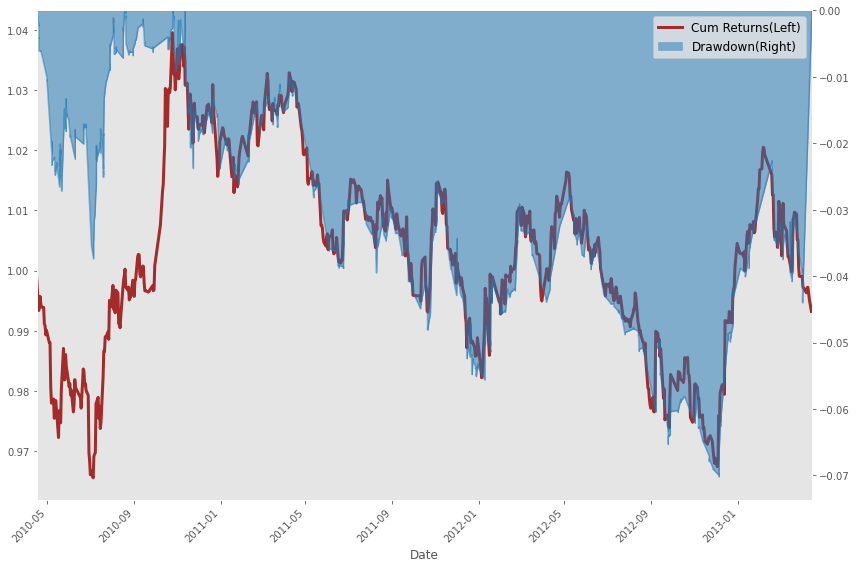

In [ ]:
# Line plot of timereturn
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1 = cumrets.plot(rot=45, grid=False, label='Cum Returns(Left)', color='brown', linewidth=3)

ax2 = ax1.twinx()
# ax2 = drawdown.plot.area(grid=False, label='Drawdown(Right)', alpha=0.5, color='tab:blue', linewidth=3)
ax2 = plot_df['drawdown'].plot.area(grid=False, label='Drawdown(Right)', alpha=0.5, color='tab:blue')

# ax1.set_ylim(0.0, 1.40)
ax1.yaxis.set_ticks_position('left')
ax2.yaxis.set_ticks_position('right')

ax1.set_xlabel('Date')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, fontsize=12, ncol=1, loc='upper right')
plt.margins(x=0)
fig.tight_layout()

# ax1.set_title('累计收益率曲线')

plt.show()

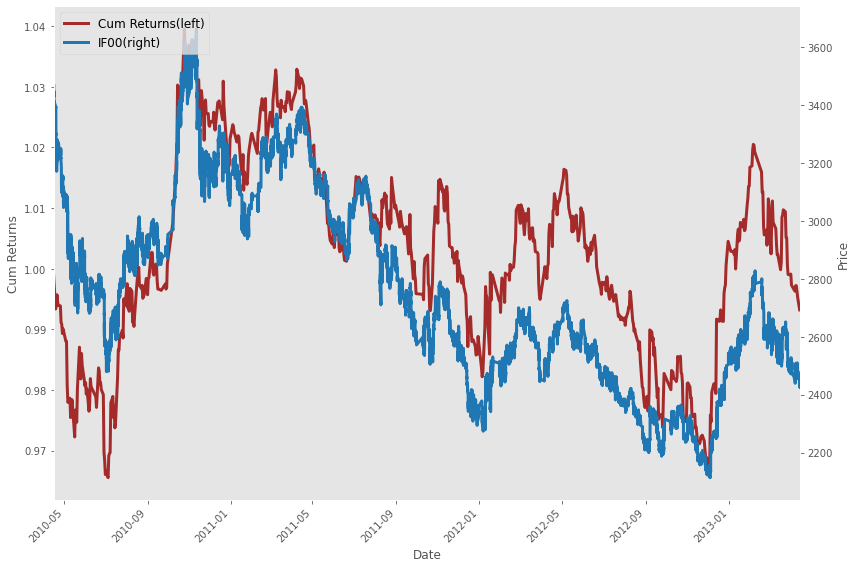

In [ ]:
# Line plot of rets/prices
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.set_xlabel('Date')
ax1.set_ylabel('Cum Returns')
cumrets.plot(ax=ax1, grid=False, rot=45, label='Cum Returns(left)', color='brown', linewidth=3)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('Price')
# df['S_DQ_ADJCLOSE'].loc[var.fromdate:var.todate].plot(ax=ax2, color='tab:blue', linewidth=3, grid=False, label=var.contract + '(right)')
df['S_DQ_CLOSE'].loc[var.fromdate:var.todate].plot(ax=ax2, color='tab:blue', linewidth=3, grid=False, label=var.contract + '(right)')
ax2.tick_params(axis='y')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, fontsize=12, ncol=1, loc='upper left')

plt.margins(x=0)
fig.tight_layout()
plt.show()

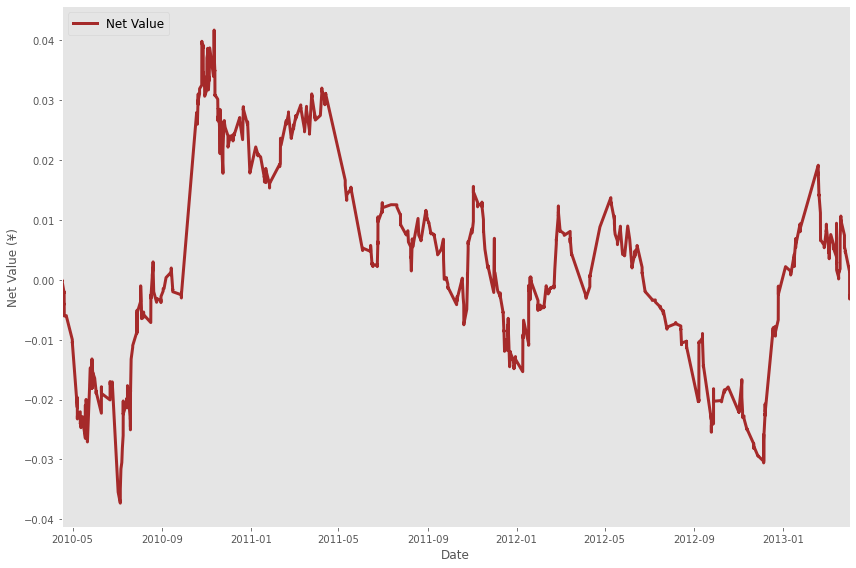

In [ ]:
# 净值曲线
net_value = plot_df['value'] / var.startcash - 1

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Net Value (¥)')
ax = plt.plot(net_value, label='Net Value', color='brown', linewidth=3)


plt.margins(x=0)
plt.grid(False)
plt.legend(loc='upper left', fontsize=12)
fig.tight_layout()
plt.show()